# Capstone 2 - Machine learning (Unsupervised learning)

In [100]:
# importing required libraries
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler

In [101]:
df = pd.read_csv('UsArrests.csv') # loading UsArrests data set
df.head() # getting view of data

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [102]:
df.info() # inspecting to see that all independent variables are either ints or floats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
City        50 non-null object
Murder      50 non-null float64
Assault     50 non-null int64
UrbanPop    50 non-null int64
Rape        50 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.0+ KB


In [103]:
df.columns # printing column names to use when creating X and y

Index(['City', 'Murder', 'Assault', 'UrbanPop', 'Rape'], dtype='object')

#### Seperating X and y from df

In [104]:
features = ['Murder', 'Assault', 'UrbanPop', 'Rape']
# Separating out the features
X = df.loc[:, features].values
# Separating out the target
y = df.loc[:, ['City']].values

#### Scaling X 

In [105]:
X = StandardScaler().fit_transform(X)

X[:5] # inspecting first 5 rows for all scaled independent variables

array([[ 1.25517927,  0.79078716, -0.52619514, -0.00345116],
       [ 0.51301858,  1.11805959, -1.22406668,  2.50942392],
       [ 0.07236067,  1.49381682,  1.00912225,  1.05346626],
       [ 0.23470832,  0.23321191, -1.08449238, -0.18679398],
       [ 0.28109336,  1.2756352 ,  1.77678094,  2.08881393]])

#### Creating pca object of scaled X

In [106]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2) # PCA based on 2 principal components
principalComponents = pca.fit_transform(X) # fitting scaled X to pca object
columns = ['principal component 1', 'principal component 2'] # columns for new dataframe
principalDf = pd.DataFrame(data = principalComponents, columns = columns) # creating new datafame with column headers for principal components

In [107]:
finalDf = pd.concat([principalDf, df[['City']]], axis = 1) # concatting the city columns (dependent variable to the dataframe) 
finalDf.head()

,principal component 1,principal component 2,City
0,0.985566,1.133392,Alabama
1,1.950138,1.073213,Alaska
2,1.763164,-0.745957,Arizona
3,-0.141420,1.119797,Arkansas
4,2.523980,-1.542934,California


#### Creating heatmap (without mirror) to show correlation between the different independent variables

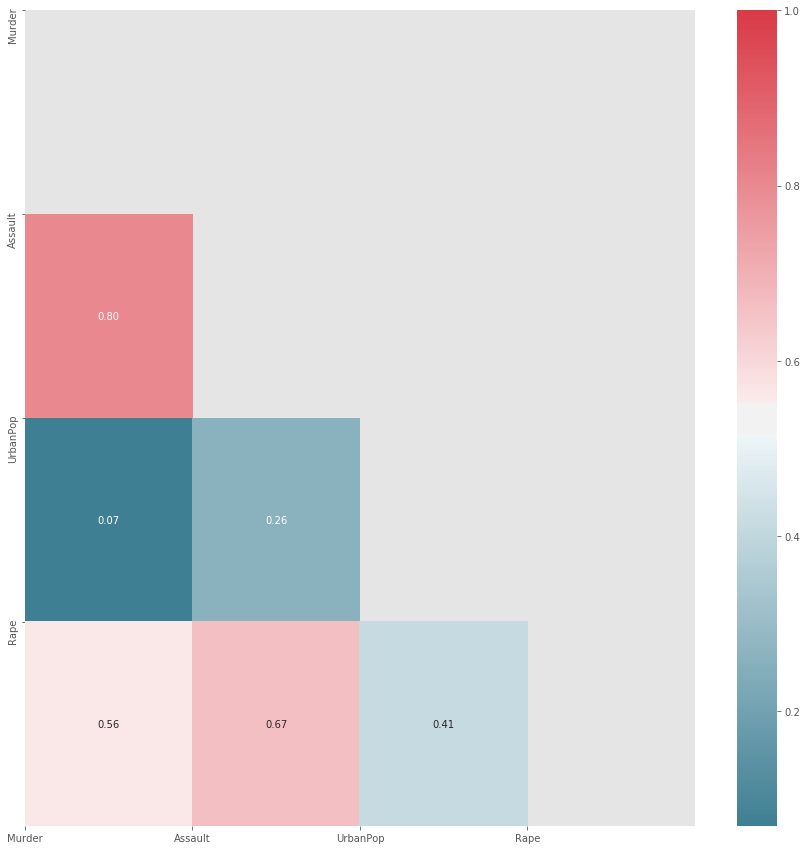

In [108]:
# Create Correlation df
corr = df.iloc[:, 1:].corr() # selecting all independent varaibles from the initial dataframe
# Plot figsize
fig, ax = plt.subplots(figsize=(15, 15))
# Generate Color Map
colormap = sns.diverging_palette(220, 10, as_cmap=True)

# Drop self-correlations so that it does not mirror 1s diagonally
dropSelf = np.zeros_like(corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
# Generate Color Map
colormap = sns.diverging_palette(220, 10, as_cmap=True)
# Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf)
# Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
# Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
# show plot
plt.show()

From the above there is positive correlations across all feature pairs with different strengths. Between Assault and Murder positive correlation is 0.80 with Rape:Assault having 0.67 correlation and Rape:Murder with 0.56 correlation. These are the three pairs with highest positive correlations. Due to these high similar correlations between these pairs these would be more redundant while performing PCA. High positive correlation between these pairs indicate that assault is highly correlated with murder, assault is also highly connected with rape while rape is a bit less connected with murder (even though still high) in the 50 US States. 

The other three pairs (with a blueish colour) have lower correlations but also drives variation with the more positive correlated features for PCA purposes. Int this regard, Urban_Pop:Murder has low ratio of 0.07 indicating no real connection. Urban_Pop has a higher correlation to assault (probably due to greater occurences of assault vs murder in a population). Rape: Urban_Pop has the highest connection for the 3 lowest pairs indicating there is some correlation between population size and the number of rapes that could occur.

#### Viewing feature components of the two principal components

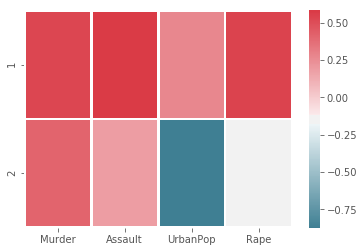

In [109]:
components = pd.DataFrame(pca.components_, columns = df.columns[1:], index=[1,2]) # components of different features 94) in 2 row dataframe

colormap = sns.diverging_palette(220, 10, as_cmap=True) # colormap with diverging colors to indicate value strength
ax = sns.heatmap(components,cmap=colormap,
                 linewidth=1.8)
plt.show()

With standardized data, UrbanPop seems to be of most importance in principal component 2 while Murder, Assault and Rape will have similar importance in principal component 1 (This will probably be confirmed in the biplot as well). This indicates that all of the variables were important for purposes of variance in PC1 and PC2 in totality except feature pairs with similar correlations.

#### Function to determine most important features

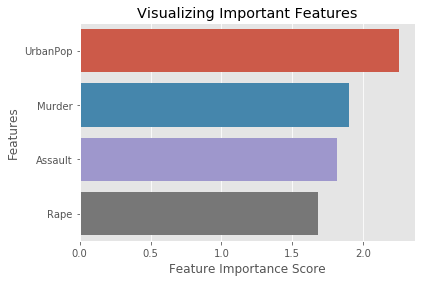

In [110]:
import math

def get_important_features(transformed_features, components_, columns):
    """
    This function will return the most "important" 
    features so we can determine which have the most
    effect on multi-dimensional scaling
    """
    num_columns = len(columns)

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    # Sort each column by it's length. These are the *original*
    # columns and not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    #print ("Features by importance:\n", important_features)
    return(important_features)
    
T = pca.transform(X)

comp = get_important_features(T, pca.components_, df.columns[1:].values)

dff = pd.DataFrame(comp, columns = ['Importance', 'Variable'])
                  
# Creating a bar plot
sns.barplot(x=dff.iloc[:,0], y=dff.iloc[:,1])
# Adding labels to graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

Based on the above, UrbanPop is the most important feature followed by Murder, Assault and Rape. From the above the bottom 3 variables had very similar importance and also dominated PC1 (indicative that all 4 variables matter even if not at the same level)

#### Drawing a biplot to see relationship between features with transformed data

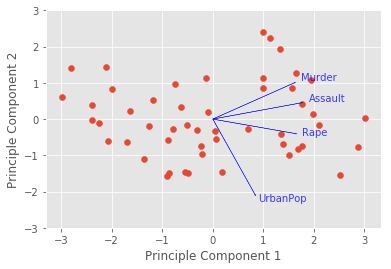

In [111]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def draw_vectors(transformed_features, components_, columns):
    """
    This funtion will project your *original* features
    onto your principal component feature-space, so that you can
    visualize how "important" each one was in the
    multi-dimensional scaling
    """

    num_columns = len(columns)

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    ax = plt.axes()

    for i in range(num_columns):
    # Use an arrow to project each original feature as a
    # labeled vector on your principal component axes
        plt.arrow(0, 0, xvector[i], yvector[i], color='b', width=0.0005, head_width=0.02, alpha=0.75)
        plt.text(xvector[i]*1.08, yvector[i]*1.08, list(columns)[i], color='b', alpha=0.75)

    return ax


ax = draw_vectors(T, pca.components_, df.columns[1:].values)
T_df = pd.DataFrame(T)
T_df.columns = ['component1', 'component2']

plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.ylim(-3, 3)
plt.scatter(T_df['component1'], T_df['component2'], alpha=1)
plt.show()

From the biplot, for arrests in the US based on specific crime, one can see Urbabpop dominating PC2 (with lesser positive correlation which is also confirmed in the heatmap) while the other 3 are more involved in PC1 and have positive correlations heading in the same direction with Murder having a bit less correlation due to its upperward angle (which is also confirmed in the heatmap and shows a bit of influence in PC2). Due to almost 90 degree angle between UrbanPop and Murder there is low correlation which is also confirmed in heatmap. Directions of lines also indicates where most of the values lie for the different variable while the length thereof also indicates its importance or explained. UrbanPop is most explained with the other 3 features being explained to a lesser extend.

Taking all the above into consideration, all 4 features were taken into account for PC1 and PC2. Redundancy would probably have been linked to the 3 features more closely associated with each other on PC1.

Points towards right of the center point are states more associated with the specific crimes (based on how close to the specific vector line they are, while those to the left are less associated with it and also has lesser crime rates.

#### Cumulative variation plot to show how much 2 principal components adress on the varaition of thedata

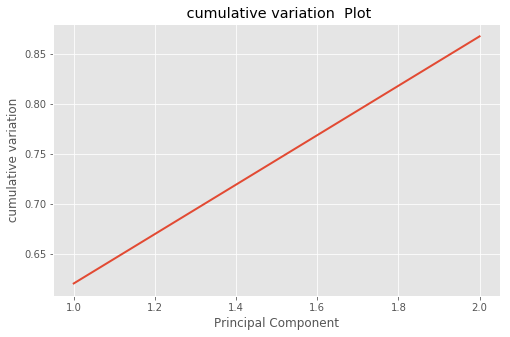

In [112]:
# generating Scree plot for the 2 PCs
fig = plt.figure(figsize=(8,5))
sing_vals = np.arange(2) + 1
plt.plot(sing_vals, np.cumsum(pca.explained_variance_ratio_), linewidth=2)
plt.title(' cumulative variation  Plot')
plt.xlabel('Principal Component')
plt.ylabel(' cumulative variation ')
plt.show()

From the graph 1 PC would cover about 62% while a second PC cumulatively already cover more than 85% tohether, which should be enough for purposes of using the PCA variables when performing agglomerative and kmeans clustering

In [113]:
pca.explained_variance_ratio_ # confirms above mentioned graph

array([0.62006039, 0.24744129])

In [114]:
pca.explained_variance_ratio_.sum() # confirms above mentioned graph

0.8675016829223339

### Starting with clustering techniques

#### Agglomerative clustering

In [115]:
X_new = finalDf.iloc[:, :2] # for ease I am creating indepent variables from finalDf dataframe which was obtained from scaled data
y_new = finalDf.iloc[:, 2] # for ease I am creating dependent variable from finalDf dataframe which was obtained from scaled data

In [125]:
# importing extra required packages
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

###### Creating 2 dendograms to see if to use average or complete linkage

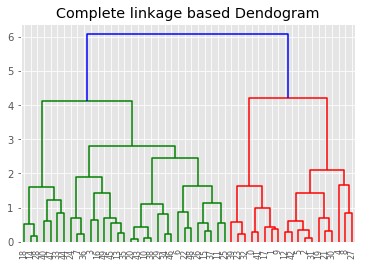

In [127]:
plt.title("Complete linkage based Dendogram")  
dend = dendrogram(linkage(X_new, method='complete')) # creating a dendogram based on complete linkage

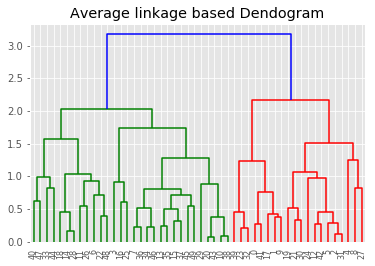

In [124]:
plt.title("Average linkage based Dendogram")  
dend = dendrogram(linkage(X_new, method='average'))

Based on the above two graph, complete linkage seems to provide the best results since it provides the "better" dispersion of clusters and longer vertival lines before settling from 2 to 1 cluster. Furthermore looking at the complete linkage dendogram, the highest vertical distance that does not intersect with any cluster is at the count of about 4. Going forward agglomerative hierarchical clustering will be done with 4 clusters and with the euclidean distance method.

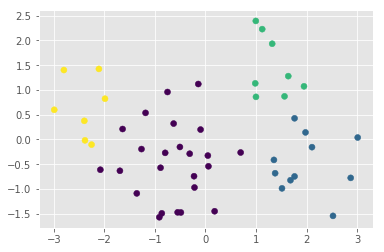

In [129]:
# Agglomerative clustering wuth 4 clusters
cluster = AgglomerativeClustering(n_clusters= 4, affinity = "euclidean", linkage = 'complete')
predictions = cluster.fit_predict(X_new)
plt.scatter(X_new.iloc[:,0], X_new.iloc[:,1], c=cluster.labels_)
plt.show()

In [128]:
predictions #gettin indication of how different states are addressed between the different clusters based on arrests for crimes

array([2, 2, 1, 0, 1, 1, 0, 0, 1, 2, 0, 0, 1, 0, 3, 0, 0, 2, 3, 1, 0, 1,
       0, 2, 0, 0, 0, 1, 3, 0, 1, 1, 2, 3, 0, 0, 0, 0, 0, 2, 3, 2, 1, 0,
       3, 0, 0, 3, 0, 0], dtype=int64)

In [130]:
from sklearn.metrics import silhouette_score

score = round(silhouette_score(X_new, predictions, metric='euclidean'),2)
score # silhouette score of 42%

0.42

Based on the above method the complete linkage model with euclidean distance method provided a silhoutte score of 0.42 indicating that there is quite a high similarity of objects in their own clusters (of which 4 were provided) compared to other clusters. One could then assume whichever cluster a state is attributed to, similar crime rates for the specific type of features occur.

#### K-means clustering

In [135]:
# Importing extra required package
from sklearn.cluster import KMeans

##### Using elbow method to determine best amount of clusters for k-means model

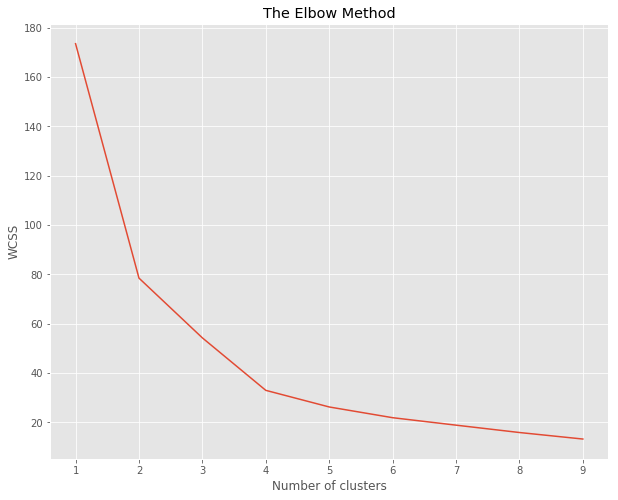

In [138]:
plt.figure(figsize=(10, 8))
wcss = [] # empty string where inertia values will be stored
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(X_new)
    wcss.append(kmeans.inertia_) #criterion based on which K-means clustering works
plt.plot(range(1, 10), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') # Within cluster sum of squares
plt.show()

Scree plot start to level out at around the value of 4 on the x-axis. As a result i will use 4 clusters for k-means model as well.

In [ ]:
km = KMeans(n_clusters = 4) # initiating k-means model with 4 clusters

In [120]:
km.fit(X_new) # fitting the independent variables into the kmeans model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [121]:
centers = km.cluster_centers_ # printing out the centers of the various clusters in the model
centers

array([[ 1.1598581 ,  1.43242831],
       [-1.96450246,  0.36712739],
       [ 1.99614581, -0.50138332],
       [-0.4033997 , -0.71466437]])

In [122]:
new_labels = km.labels_  # printing out the labels to see the k-means predictions for the various US states
new_labels 

array([0, 0, 2, 0, 2, 2, 3, 3, 2, 0, 3, 1, 2, 3, 1, 3, 1, 0, 1, 2, 3, 2,
       1, 0, 3, 1, 1, 2, 1, 3, 2, 2, 0, 1, 3, 3, 3, 3, 3, 0, 1, 0, 2, 3,
       1, 3, 3, 1, 1, 3])

Text(0.5, 1.0, 'PC1 vs PC2 via kmeans')

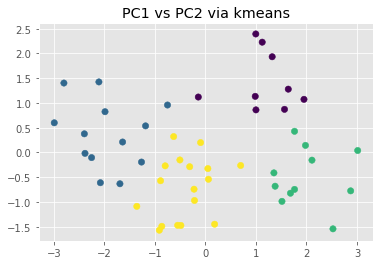

In [123]:
# plotting the k-means clusters between the 2 Principal components 
plt.scatter(X_new.iloc[:,0], X_new.iloc[:,1], c = new_labels, s=40)
plt.title('PC1 vs PC2 via kmeans')

From the above, 4 clusters are generated grouping states with similar correlation of crime stats into a cluster. Interestingly, the kmeans model is very similar to the agglomerative clustering models in the distribution of its clusters but does however differ a bit for the 2 clusters on the left of the scatterplot, indicating that grouping was a bit different for these 2 clusters. The Kmeans model also has a 2% better silhouette score (see below) indicating a higher similarity of objects in their own clusters for the kmeand model than the agglomerative model that I used.

In [140]:
score = round(silhouette_score(X_new, new_labels, metric='euclidean'),2)
score

0.44